In [76]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
import time
import copy
import cv2 
import numpy as np
input_path = "../input/data-chamber/DATA_CHAMBER_2021/" 
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
    

Using CUDA


In [77]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [78]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [79]:
def initialize_model(model_name, num_classes, feature_extract = False, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG19_bn
        """
        model_ft = models.vgg19_bn().load_state_dict(torch.load("../input/vgg19bn/vgg19_bn.pth"))
        set_parameter_requires_grad(model_ft, feature_extract)
        num_features = vgg16.classifier[6].in_features
        features = list(vgg16.classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features, len(num_classes))]) # Add our layer with 4 outputs
        vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=False)
        model_ft.load_state_dict(torch.load('../input/pretrained-pytorch-models/inception_v3_google-1a9a5a14.pth'))
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model('inception', 3,feature_extract = False, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft)

# Preprocessing data

In [80]:
def opening(img):
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=1)
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=1)
    return img_dilation
def denoise(img):
    #denoise_img = cv2.medianBlur(img,9)
    denoise_img = cv2.bilateralFilter(img, 15, 75, 75)
    return denoise_img

In [81]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [82]:
from PIL import Image
from matplotlib import cm
def preprocessing(img):
    return Image.fromarray(np.uint8(apply_brightness_contrast(opening(denoise(np.array(img))),0,16)))


# Load dữ liệu

In [83]:

data_transforms = {
    'train': transforms.Compose([
        preprocessing,
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        #transforms.RandomHorizontalFlip(),
        #transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
    'validation': transforms.Compose([
        preprocessing,
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



image_datasets = {
    'train':
    ImageFolderWithPaths(input_path + 'train', data_transforms['train']),
    'validation': 
    ImageFolderWithPaths(input_path + 'test', data_transforms['validation'])
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','validation']}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=4),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=4)  # for Kaggle
}
class_names = image_datasets['train'].classes

# See some statistics
print(dataloaders)
len(dataloaders['train'])

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4099f11c18>, 'validation': <torch.utils.data.dataloader.DataLoader object at 0x7f4099f11e48>}


210

### Visualize a few images

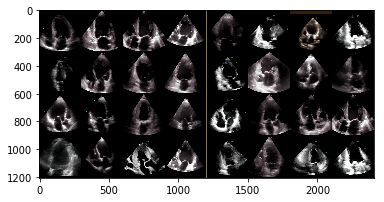

In [84]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# def imshow(inp, title=None):
#     inp = inp.numpy().transpose((1, 2, 0))
#     # plt.figure(figsize=(10, 10))
#     plt.axis('off')
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)


# Get a batch of training data
inputs, classes,_ = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

# imshow(out, title=[class_names[x] for x in classes])

## 2. General functions to train and visualize

Here we use a general function to train a model. It includes:

* Scheduling the learning rate
* Saving the best model

We use [*torch.optim.lr_scheduler*](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate). It provides several methods to adjust the learning rate based on the number of epochs. Our function parameter `scheduler` is an object from it.

In [85]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2, is_inception=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_values = []
    acc_values = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels,_ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    # mode we calculate the loss by summing the final output and the auxiliary output
                    # but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                del inputs,labels

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            loss_values.append(epoch_loss)
            acc_values.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,acc_values,loss_values

### Visualizing the model predictions

A generic function to display predictions for a few images.

In [86]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels,_) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 3. Transfer learning: feature extractor

### Inception v3

Inception v3 was first described in [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/pdf/1512.00567v1.pdf). This network is unique because it has two output layers when training. 

The second output is known as an auxiliary output and is contained in the AuxLogits part of the network. The primary output is a linear layer at the end of the network. 

Note, when testing we only consider the primary output. 

## 4. Train and evaluate

We use [torch.optim.lr_scheduler.StepLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR) to schedule the learning rate.

In [87]:

def test_model(model, criterion, optimizer):
    labels_input=list()
    labels_output=list()
    vid_id = list()
    for phase in ['validation']:
        model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels, fname in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_input= labels_input + labels.tolist()
            for f in fname:
                vid_id.append(f.split('/')[-1].split('.')[0].split('_')[0])
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            labels_output= labels_output + preds.tolist()
    return labels_input,labels_output,vid_id
            
# y_true,y_pred,vid_id = test_model(model, criterion, optimizer)

In [88]:
def plot_history(history,loss,acc): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(loss, 'r', label="training loss")
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('loss', color='r')
    ax1.legend(loc="best", fontsize=9)    
    ax1.tick_params('y', colors='r')

    ax2 = ax1.twinx()
    ax2.plot(acc, 'b', label="training acc")
    ax2.legend(loc="lower right", fontsize=9)
    ax2.set_ylabel('acc', color='b')        
    ax2.tick_params('y', colors='b')

In [89]:
#../input/data-chamber/DATA_CHAMBER_2021/test/2C/158_0.jpg

In [90]:
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer_conv = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()
# Decay LR by a factor of 0.1 every epoch
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=1, gamma=0.1)

In [91]:
model_ft,acc,loss = train_model(model_ft, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10, is_inception=True) 

Epoch 1/10
----------
train Loss: 0.2137 Acc: 0.9284
validation Loss: 0.1612 Acc: 0.9459

Epoch 2/10
----------
train Loss: 0.0045 Acc: 0.9993
validation Loss: 0.1132 Acc: 0.9701

Epoch 3/10
----------
train Loss: 0.0026 Acc: 0.9996
validation Loss: 0.1291 Acc: 0.9695

Epoch 4/10
----------
train Loss: 0.0014 Acc: 1.0000
validation Loss: 0.1176 Acc: 0.9670

Epoch 5/10
----------
train Loss: 0.0021 Acc: 0.9999
validation Loss: 0.1183 Acc: 0.9676

Epoch 6/10
----------
train Loss: 0.0015 Acc: 1.0000
validation Loss: 0.1239 Acc: 0.9664

Epoch 7/10
----------
train Loss: 0.0024 Acc: 0.9999
validation Loss: 0.1310 Acc: 0.9701

Epoch 8/10
----------
train Loss: 0.0017 Acc: 0.9999
validation Loss: 0.1256 Acc: 0.9645

Epoch 9/10
----------
train Loss: 0.0021 Acc: 0.9994
validation Loss: 0.1121 Acc: 0.9701

Epoch 10/10
----------
train Loss: 0.0020 Acc: 0.9999
validation Loss: 0.1357 Acc: 0.9658

Training complete in 68m 11s
Best val Acc: 0.970131


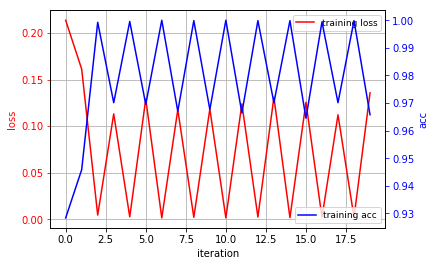

In [92]:
plot_history(model_ft,loss,acc)

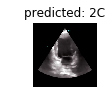

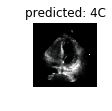

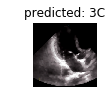

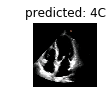

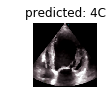

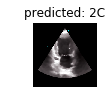

In [93]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [94]:
y_true,y_pred,vid_id = test_model(model_ft, criterion, optimizer_conv)


In [95]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true,y_pred)

0.970130678282514

In [96]:
import pandas as pd
import glob


df = pd.DataFrame(list(zip(y_true,y_pred,vid_id)),columns =['y_true','y_pred','vid_id'])
df.to_csv('df.csv',encoding='utf-8',index=False)

vid_list = list(set(df['vid_id'].values))
y_true = []
y_pred = []
for vid in vid_list:
    #print(vid)
    tmp_df = df[df['vid_id']==vid]
    #print(len(tmp_df))
    vid_pred = tmp_df['y_pred'].mode().values[0]
    vid_label = tmp_df['y_true'].mode().values[0]
    y_true.append(vid_label)
    y_pred.append(vid_pred)
    #print(vid_label,"\n",vid_pred)
    
    #print('vid: {} label: {} pred: {}'.format(vid,vid_label,vid_pred))

In [97]:
df.head(10)

,y_true,y_pred,vid_id
0,2,2,182
1,2,2,164
2,2,2,160
3,1,1,189
4,1,1,175
5,1,1,185
6,2,2,188
7,0,0,176
8,0,0,181
9,1,1,185


In [98]:
accuracy_score(y_true,y_pred)

0.9743589743589743

In [99]:
import glob
path = '../input/data-chamber/DATA_CHAMBER_2021/train/'
class_count = {}
label = []
for f in ['2C','3C','4C']:
    class_count[f] = len(glob.glob(f'../input/data-chamber/DATA_CHAMBER_2021/train/{f}/*'))
    label = label + [f]*class_count[f]
    print(f'Number sample per class {f}: {class_count[f]}')
    

Number sample per class 2C: 2377
Number sample per class 3C: 2309
Number sample per class 4C: 2031


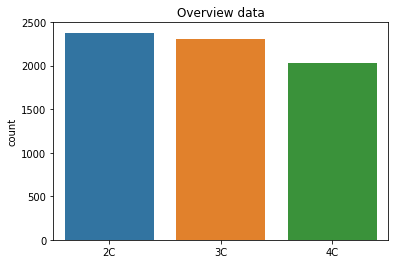

In [100]:
import seaborn as sns
def countplot_comparison(feature):
    s1 = sns.countplot(feature)
    s1.set_title("Overview data")
countplot_comparison(label)